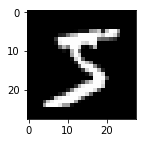

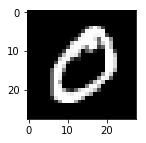

In [2]:
import numpy as np

import time

# load MNIST data
import h5py

MNIST_data = h5py.File('MNISTdata.hdf5', 'r')
x_train = np.float32(MNIST_data['x_train'][:])
y_train = np.int32(np.array(MNIST_data['y_train'][:, 0]))
x_test = np.float32(MNIST_data['x_test'][:])
y_test = np.int32(np.array(MNIST_data['y_test'][:, 0]))

MNIST_data.close()


###########################################################################
#####plot the images..

def PlotImage(vector_in, time_to_wait):
    array0 = 255.0 * np.reshape(vector_in, (28, 28))
    from matplotlib import pyplot as plt
    plt.ion()
    plt.show(block=False)
    plt.figure(figsize=(2, 2))
    plt.imshow(array0, cmap='Greys_r')
    plt.draw()
    plt.show()
    time.sleep(time_to_wait)
    plt.close('all')


# time (in seconds) between each image showing up on the screen
time_to_wait = 1
# number of images from the dataset that will be plotted
N = 100
# plot the images
for i in range(0, 2):
    PlotImage(x_train[i], time_to_wait)

In [43]:
def activation_forward(x,func_name):
    if func_name.lower() =='relu':
        y = x * (x > 0)
    elif func_name.lower() == 'tanh':
        y = 1.0 - 2.0/(1 + np.exp(2 * x))
    elif func_name.lower() == 'sigmoid':
        y = 1.0/(1.0 + np.exp(-x))
    elif func_name.lower() == 'softmax':
        y = np.exp(x)/np.sum(np.exp(x),axis = 0,keepdims = 1)
    else:
        raise NameError("The function's name must be one of them:'ReLU','Tanh','Sigmoid','Softmax'")
    return y
def activation_backward(A1,func_name):
    if func_name.lower() =='relu':
        y = np.ones(A1.shape) * (A1 > 0)
    elif func_name.lower() == 'tanh':
        y = 1 - A1**2
    elif func_name.lower() == 'sigmoid':
        y = A1 * (1 - A1)
    else:
        raise NameError("The function's name must be one of them:'ReLU','Tanh','Sigmoid'")
    return y

In [44]:
def initialize_parameters(layers):
    L = len(layers)
    parameters = {}
    for i in range(1,L):
        parameters['W'+str(i)] = np.random.randn(layers[i],layers[i-1]) * np.sqrt(1./layers[i])    
        parameters['b'+str(i)] = np.zeros((layers[i],1)) 
    return parameters

In [92]:
def forward_propagation(X,Y,parameters,keep_probs,activation_name):
    L = int(len(parameters)/2)
    cache = {}
    cache['A0'] = X
    
    for i in range(1,L):
        cache['Z' + str(i)] = np.dot(parameters['W' + str(i)], cache['A' + str(i-1)]) + parameters['b' + str(i)]
        cache['D' + str(i)] = np.random.rand(cache['Z' + str(i)].shape[0],cache['Z' + str(i)].shape[1]) < keep_probs['L' + str(i)]
        cache['A' + str(i)] = activation_forward(cache['Z' + str(i)],activation_name) * cache['D' + str(i)] / keep_probs['L' + str(i)]

    cache['Z' + str(L)] = np.dot(parameters['W' + str(L)], cache['A' + str(L-1)]) + parameters['b' + str(L)]
    cache['A' + str(L)] = activation_forward(cache['Z' + str(L)],'softmax')
    
    cost = loss_func(cache['A' + str(L)],Y)
    return cache,cost

In [93]:
def backward_propagation(X,Y,cache,parameters,keep_probs,activation_name):
    m = Y.shape[1]
    L = int(len(parameters)/2)
    
    gradients = {}
    dZ_temp = cache['A' + str(L)] - Y
    gradients['dW' + str(L)] = 1./m * np.dot(dZ_temp,cache['A' + str(L - 1)].T)
    gradients['db' + str(L)] = 1./m * np.sum(dZ_temp,axis = 1, keepdims = True)
    
    for i in range(L-1,0,-1):
        dA_temp = np.dot(parameters['W' + str(i + 1)].T, dZ_temp) * cache['D' + str(i)] / keep_probs['L' + str(i)]
        dZ_temp = dA_temp * activation_backward(cache['A' + str(i)],activation_name)
        gradients['dW' + str(i)] = 1./m * np.dot(dZ_temp,cache['A' + str(i-1)].T)
        gradients['db' + str(i)] = 1./m * np.sum(dZ_temp, axis = 1, keepdims = True)

    return gradients

In [94]:
def updata_parameters(parameters,gradients,alpha):
    L = int(len(parameters)/2)
    for i in range(1,L+1):
        parameters['W' + str(i)] -= alpha * gradients['dW' + str(i)]
        parameters['b' + str(i)] -= alpha * gradients['db' + str(i)]
    return parameters

In [95]:
def loss_func(AL,Y):
    m = Y.shape[1]
    J = -1.0/m * np.sum(Y * np.log(AL))
    return J

In [96]:
def train_model(X,Y,num_class,layers,keep_probs,iterations,activation_name,alpha,batch_size):
    parameters = initialize_parameters(layers)
    sample_size = Y.shape[1]
    for i in range(iterations):
        index = np.arange(sample_size)  
        random.shuffle(index)
        for j in range(sample_size//batch_size):
            start = j*batch_size
            end = min((j+1)*batch_size,sample_size)
            X_batch = X[:,index[start:end]]
            Y_batch = Y[:,index[start:end]]
            cache,cost = forward_propagation(X_batch,Y_batch,parameters,keep_probs,activation_name)
            gradients = backward_propagation(X_batch,Y_batch,cache,parameters,keep_probs,activation_name)
            parameters = updata_parameters(parameters,gradients,alpha)
        
        if i % 10 == 0 or i == iterations -1:
            #train_y_hat,train_accuracy = prediction(X_train,y_train,parameters,activation_name)
            print('Cost value after %-5d iterations: %f'%(i,cost))
            #print('training accuracy after %-5d iterations: %f'%(i,train_accuracy))
            
    return parameters

In [97]:
def prediction(X,y,parameters,activation_name):
    A = X
    L = int(len(parameters)/2)
    for i in range(1,L):
        Z = np.dot(parameters['W' + str(i)],A) + parameters['b' + str(i)]
        A = activation_forward(Z,activation_name)
    
    Z = np.dot(parameters['W' + str(L)],A) + parameters['b' + str(L)]
    A = activation_forward(Z,'softmax')
    y_hat = A.argmax(axis=0)
    accuracy = sum(y_hat == y)/len(y)
    return y_hat,accuracy

In [100]:
import random
import time
X_train = x_train.T
X_test = x_test.T
num_class = len(set(y_train))
Y_train = np.zeros((num_class,len(y_train)))
for i in range(len(y_train)):
    Y_train[y_train[i]][i] = 1
    
layers = [X_train.shape[0],50,num_class]
keep_probs = {'L1':0.5}
iterations = 50
activation_name = 'relu'
alpha = 0.1
batch_size = 32

start_time = time.time()
parameters = train_model(X_train,Y_train,num_class,layers,keep_probs,iterations,activation_name,alpha,batch_size)
end_time = time.time()

train_y_hat,train_accuracy = prediction(X_train,y_train,parameters,activation_name)
test_y_hat,test_accuracy = prediction(X_test,y_test,parameters,activation_name)
print("Traing time:%f second"%(end_time - start_time))
print("Traing accuracy:%f"%(train_accuracy))
print("Test accuracy:%f"%(test_accuracy))

Cost value after 0     iterations: 0.739541
Cost value after 10    iterations: 0.425487
Cost value after 20    iterations: 0.403918
Cost value after 30    iterations: 0.309715
Cost value after 40    iterations: 0.419985
Cost value after 49    iterations: 0.227901
Traing time:41.905421 second
Traing accuracy:0.978433
Test accuracy:0.962400


In [40]:
import random
X_train = x_train.T
X_test = x_test.T
num_class = len(set(y_train))
Y_train = np.zeros((num_class,len(y_train)))
for i in range(len(y_train)):
    Y_train[y_train[i]][i] = 1
#hidden_units = 20
#alpha = 0.01
iterations = 100
activation_name = 'relu'
batch_size = 50


train_accuracy = {}
test_accuracy = {}
for alpha in [0.001,0.005,0.01,0.05,0.1]:
    train_accuracy[alpha] = {}
    test_accuracy[alpha] = {}
    for hidden_units in [500]:
        parameters = train_model(X_train,Y_train,num_class,hidden_units,iterations,activation_name,alpha,batch_size)
        train_y_hat,train_accuracy[alpha][hidden_units] = prediction(X_train,y_train,parameters,activation_name)
        test_y_hat,test_accuracy[alpha][hidden_units] = prediction(X_test,y_test,parameters,activation_name)
        print("Learning rate : %f\nhidden units: %d"%(alpha,hidden_units))
        print("Accuracy for training data set: %f"%(train_accuracy[alpha][hidden_units]))
        print("Accuracy for test data set: %f\n"%(test_accuracy[alpha][hidden_units]))

Cost value after 0     iterations: 1.632896
Cost value after 10    iterations: 0.280791
Cost value after 20    iterations: 0.352292
Cost value after 30    iterations: 0.275275
Cost value after 40    iterations: 0.196536
Cost value after 50    iterations: 0.272568
Cost value after 60    iterations: 0.321050
Cost value after 70    iterations: 0.367852
Cost value after 80    iterations: 0.192594
Cost value after 90    iterations: 0.344489
Cost value after 99    iterations: 0.098283
Learning rate : 0.001000
hidden units: 500
Accuracy for training data set: 0.943600
Accuracy for test data set: 0.943200

Cost value after 0     iterations: 0.541569
Cost value after 10    iterations: 0.362156
Cost value after 20    iterations: 0.109321
Cost value after 30    iterations: 0.039416
Cost value after 40    iterations: 0.115886
Cost value after 50    iterations: 0.100839
Cost value after 60    iterations: 0.046916
Cost value after 70    iterations: 0.041169
Cost value after 80    iterations: 0.08449

In [44]:
performance = {}
performance['train']={}
performance['test']={}
performance['train']['0.001']=[0.861000,0.917550,0.933117,0.935400,0.939783,0.943600]
performance['test']['0.001']=[0.864300,0.918000,0.932500,0.935300,0.939400,0.943200]
y1 = performance['test']['0.001']

performance['train']['0.005']=[0.893967,0.940667,0.963433,0.974683,0.979717,0.983900]
performance['test']['0.005']=[0.889900,0.934300,0.957200,0.965900,0.971100,0.975400]
y2 = performance['test']['0.005']

performance['train']['0.01']=[0.895833,0.946467,0.967917,0.986917,0.990050,0.994183]
performance['test']['0.01']=[0.891000,0.939100,0.957700,0.973000,0.976500,0.979700]
y3 = performance['test']['0.01']

performance['train']['0.05']=[0.909850,0.957483,0.979667,0.999783,0.999983,1.000000]
performance['test']['0.05']=[0.900700,0.940700,0.956500,0.973200,0.980400,0.982200]
y4 = performance['test']['0.05']

performance['train']['0.1']=[0.908333,0.958150,0.980817,1.000000,1.000000,1.000000]
performance['test']['0.1']=[0.897600,0.939800,0.950700,0.973100,0.980500,0.982300]
y5 = performance['test']['0.1']

/Users/bangguo/anaconda/envs/py3/lib/python3.6/site-packages/matplotlib/legend.py:634: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x1239f29e8>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)
/Users/bangguo/anaconda/envs/py3/lib/python3.6/site-packages/matplotlib/legend.py:634: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x1239025f8>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)
/Users/bangguo/anaconda/envs/py3/lib/python3.6/site-packages/matplotlib/legend.py:634: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x1239f2ba8>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_han

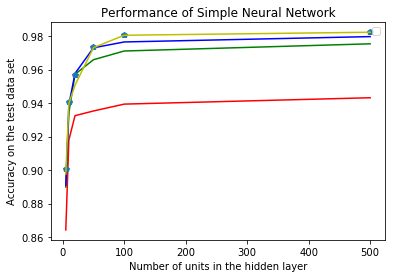

In [49]:
import pylab as pl
x1 = [5, 10, 20, 50, 100, 500]
plot1 = pl.plot(x1, y1, 'r')# use pylab to plot x and y : Give your plots names
plot2 = pl.plot(x1, y2, 'g')
plot3 = pl.plot(x1, y3, 'b')
plot4 = pl.plot(x1, y4, 'p')
plot5 = pl.plot(x1, y5, 'y')
 
pl.title('Performance of Simple Neural Network')# give plot a title
pl.xlabel('Number of units in the hidden layer')# make axis labels
pl.ylabel('Accuracy on the test data set')
 
 
#pl.xlim(0.0, 9.0)# set axis limits
#pl.ylim(0.0, 30.)
 

pl.legend([plot1, plot2, plot3, plot4, plot5], ('red line', 'green line','blue line','pink line','yellow line'))# make legend
pl.show()# show the plot on the screen